# `analysis`

In [ ]:
#| default_exp analysis

In [ ]:
#| export
import numpy as np
import math

In [ ]:
#| hide
import matplotlib.pyplot as plt
from nbdev import show_doc
from andi_datasets.models_phenom import models_phenom

# Angle calculation

In [ ]:
#| export 
def get_angle(a:tuple, # 2d position point A
              b:tuple, # 2d position point B
              c:tuple # 2d position point C       
             ) -> tuple:  # angle between segments AB and BC points
                
    ''' Calculates the angle between the segments generate by three points '''
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def dataset_angles(trajs:list, # set of trajectories from which to calculate angles
                  ) -> list: # list of angles between displacements
    '''Given a set of trajectories, calculate all angles between displacements'''
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

# MSD based analysis 

In [ ]:
#| export
class msd_analysis():
    def __init__(self):
        ''' Contains mean squared displacement (MSD) based methods to analyze trajectories.  '''
        

    def tamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              dim = 1
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        tamsd = np.zeros((len(t_lags), trajs.shape[0]), dtype= float)
        
        for idx, tlag in enumerate(t_lags):                  
            tamsd[idx, :] = ((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1).mean(1)
                                   
            
        return tamsd    

    def get_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
        if len(trajs.shape) == 1:
            trajs = trajs[np.newaxis, :, np.newaxis]
        
        if not t_lags:
            N_t_lags = max(4, int(trajs.shape[1]*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(trajs, t_lags)
        
        return np.polyfit(t_lags, tasmd, deg = 1)[0, :]/2/trajs.shape[-1]

    def get_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
        if len(trajs.shape) == 1:
            trajs = trajs[np.newaxis, :, np.newaxis]
        
        if not t_lags:
            N_t_lags = max(4, int(trajs.shape[1]*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(trajs, t_lags)
        
        return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]
    
    

In [ ]:
show_doc(msd_analysis.tamsd)

In [ ]:
show_doc(msd_analysis.get_diff_coeff)

Here we show an example for the calculation of the diffusion coefficient of a 2D Brownian motion trajectory. We create trajectories from displacements of variance $\sigma =1$, which results in a diffusion coefficient $D=0.5$.

<matplotlib.legend.Legend>

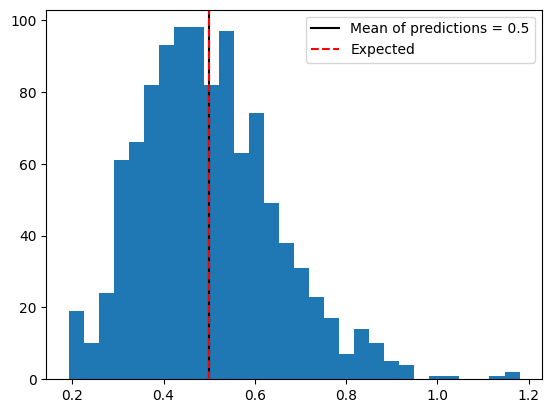

In [ ]:
pos = np.cumsum(np.random.randn(1070, 100, 2), axis = 1)
D = msd_analysis().get_diff_coeff(pos)

plt.hist(D, bins = 30);
plt.axvline(np.mean(D), c = 'k', label = f'Mean of predictions = {np.round(np.mean(D), 2)}')                                                                  
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

In [ ]:
show_doc(msd_analysis.get_exponent)

To showcase this function, we generate fractional brownian motion trajectories with $\alpha = 0.5$ and calculate their exponent:

In [ ]:
trajs.shape

(100, 1000, 2)

(1001, 100, 2)


<matplotlib.legend.Legend>

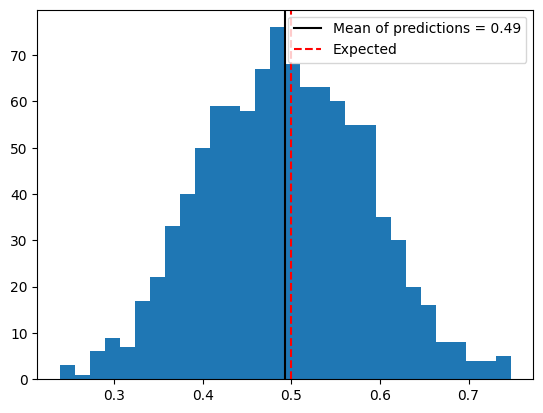

In [ ]:
trajs, _ = models_phenom().single_state(N = 1001, T = 100, alphas = 0.5, dim = 2)
alpha = msd_analysis().get_exponent(trajs.transpose(1,0,2))

plt.hist(alpha, bins = 30);
plt.axvline(np.mean(alpha), c = 'k', label = f'Mean of predictions = {np.round(np.mean(alpha), 2)}')
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

# Velocity Autocorrelation Function (VACF)

In [ ]:
#| export
def vacf(trajs, 
         delta_t:int | list | np.ndarray  = 1, 
         taus:bool | list | np.ndarray = None):
    '''
    Calculates the velocity autocorrelation function for 
    the given set of trajectories.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    delta_t : int | list | array
     If not None, the vacf is calculated in the demanded time lags. 
        
    taus : bool |  list | array
     Time windows at wich the vacf is calculated. 
    
    Returns
    -------
    np.array
        VACF of the given trajectories and the given time windows.        
    '''
    if isinstance(delta_t, int): delta_t = [delta_t]
    
    if taus is None: taus = np.arange(1, trajs.shape[1]).astype(int)
        
    V = np.zeros((len(delta_t), len(taus)))
    for idx_d, delta in enumerate(delta_t):
        # Calculate the velocity
        velocity = trajs[: ,delta:] - trajs[:,:-delta]
        velocity /= delta_t   
    
    
        for idx_t, tau in enumerate(taus):
            if tau == 0:
                V[idx_d, idx_t] = (velocity**2).mean()
            else:
                V[idx_d, idx_t] = (velocity[:, :-tau]*velocity[:, tau:]).mean()
        V[idx_d, :] /= V[idx_d, 0]
        
    return V

We show here an example of the VACF for FBM trajectories at various time lages, showing that they all coincide (as expected for this diffusion model).

Text(0.5, 0, '$\\tau / \\delta$')

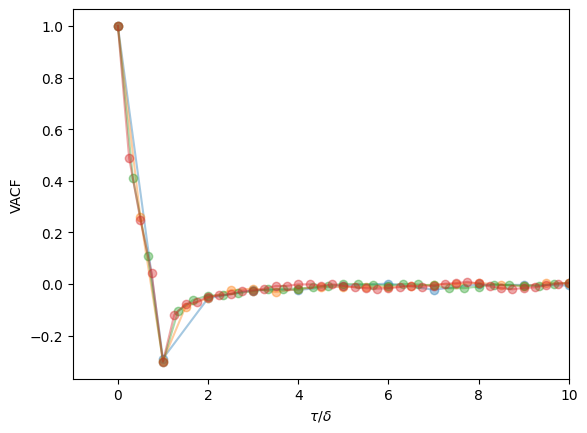

In [ ]:
deltats = np.arange(1, 5).tolist()
taus = np.arange(0, 100)
trajs, _ = models_phenom().single_state(N = 200, T = 200, alphas = 0.5)
trajs = trajs.transpose(1, 0, 2)[:,:,0]

for deltat in deltats:  
    v = vacf(trajs, deltat, taus)        
    plt.plot(taus/deltat, v.flatten(), 'o-', alpha = 0.4)    
plt.xlim(-1, 10)
plt.ylabel('VACF'); plt.xlabel(r'$\tau / \delta$')

# Convex hull analysis

In [ ]:
#| export
from scipy.spatial import ConvexHull

def CH_changepoints(trajs, 
                    tau:int = 10, 
                    metric:{'volume', 'area'} = 'volume'):
    ''' 
    Computes the changes points a multistate trajectory based on the Convex Hull approach proposed in PRE 96 (022144), 2017.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    tau : int
     Time window over which the CH is calculated.
        
    metric : {'volume', 'area'} 
     Calculate change points w.r.t. area or volume of CH.
    
    Returns
    -------
    list
        Change points of the given trajectory.
    '''
    
    CPs = []
    for traj in trajs:
        traj = np.array(traj)

        Sd = np.zeros(traj.shape[0]-2*tau)
        for k in range(traj.shape[0]-2*tau):
            if metric == 'volume':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
            elif metric == 'area':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).area

        below_mean = Sd < Sd.mean()
        cp_traj = np.argwhere(below_mean[1:] != below_mean[:-1])+1
        CPs.append(cp_traj+tau)

    return CPs

We showcase the use of the convex hull in a Brownian motion trajectory with two distinct diffusion coefficients, one 10 times the other:

Text(0, 0.5, '$S_d(n)$')

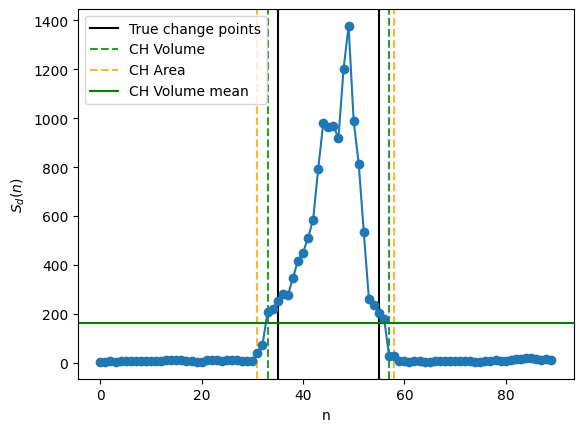

In [ ]:
# Generate trajectories and plot change points
T = 100; on = 40; off = 60; tau = 5
traj = np.random.randn(T, 2)
traj[on:off, :] = traj[on:off, :]*10
traj = traj.cumsum(0)
plt.axvline(on-tau, c = 'k')
plt.axvline(off-tau, c = 'k', label = 'True change points')

# Calculate variable Sd 
Sd = np.zeros(traj.shape[0]-2*tau)
for k in range(traj.shape[0]-2*tau):       
    Sd[k] = ConvexHull(traj[k:(k+2*tau)], ).volume  

# Compute change points both with volume and area
CPs = CH_changepoints([traj], tau = tau)[0].flatten()-tau
CPs_a = CH_changepoints([traj], tau = tau, metric = 'area')[0].flatten()-tau


# Plot everything
label_cp = 'CH Volume'
for cp in CPs:
    plt.axvline(cp, c = 'g', alpha = 0.8, ls = '--', label = label_cp)
    label_cp = ''
label_cp = 'CH Area'    
for cp in CPs_a:
    plt.axvline(cp, alpha = 0.8, ls = '--', c = 'orange', label = label_cp)
    label_cp = ''
    
plt.plot(Sd, '-o')
plt.axhline(Sd.mean(), label = 'CH Volume mean', c = 'g',)
plt.legend()
plt.xlabel('n'); plt.ylabel(r'$S_d(n)$')

# Cramér-Rao lower bound
> Expressions of the CRLB for the estimation of the diffusion coefficient for trajectories without noise, for dimension 1 and 2, at different trajectory lengths

In [ ]:
#| export
def CRLB_D(T:int, # Length of the trajectory
           dim:int = 1 # Dimension of the trajectoy
          ) ->float: # Cramér-Rao bound 
    '''
    Calculates the bound for S(D)/D, i.e. ratio between the standard deviation and the expected value of D
    This holds for x->0 only (i.e. no noise)! See PRE 85, 061916 (2012) for full equation.
    '''
    if dim == 1:
        return 2*((4-3*T)/((4-2*T)*(T-1)))**(1/2)
    if dim == 2:
        return ((3*T-4)/((T-1)*(T-2)))**(1/2)

Here we show how for Brownian motion trajectories, the MSD with is optimal and converges to the CRLB.

In [ ]:
#eval: false
Ts = np.arange(10, 100) # Trajectory lengths
Ds = np.arange(0.5, 2.1, 0.5) # We will test on different diffusion coefficients

# Saving the standard deviations
std_ds = np.zeros((len(Ds), len(Ts)))

for idxD, D in enumerate(tqdm(Ds)):
    
    # Generate the BM trajectories with given parameters
    trajs = (np.sqrt(2*D)*np.random.randn(int(1e4), Ts[-1], 1)).cumsum(1) 

    for idxL, T in enumerate(tqdm(Ts)):
        
        std_ds[idxD, idxL] = np.array(msd_analysis().get_diff_coeff(trajs = trajs[:, :T], t_lags = [1,2])).std()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

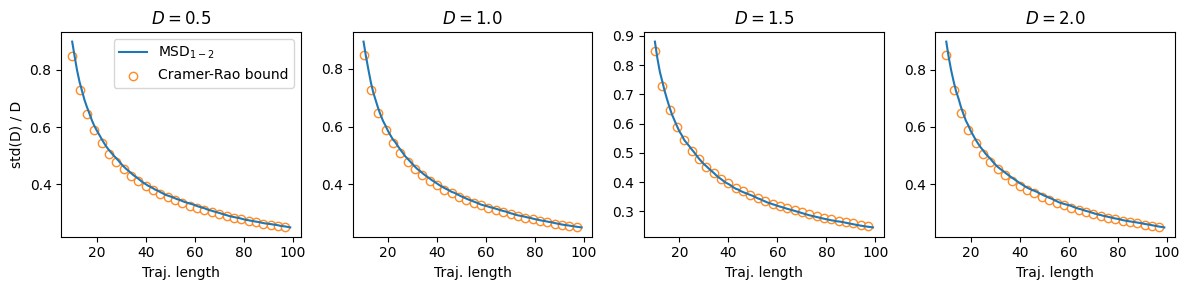

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (4*3,3), tight_layout = True)

for idx, (ax, std_d, D) in enumerate(zip(axs.flatten(), std_ds, Ds)):
    ax.plot(Ts, std_d/D, label = r'MSD$_{1-2}$')
    ax.scatter(Ts[::3], CRLB_D(Ts)[::3], label = 'Cramer-Rao bound', alpha = 0.9, facecolor = 'w', edgecolor = 'C1')
    ax.set_title(fr'$D = {D}$')
axs[0].legend()
plt.setp(axs[0], ylabel = 'std(D) / D')
plt.setp(axs, xlabel = 'Traj. length');

Here is now the same calculation for 2D trajectories, showing that we get the same convergence!

In [ ]:
#| hide
Ts = np.arange(10, 100) # Trajectory lengths
Ds = np.arange(0.5, 2.1, 0.5) # We will test on different diffusion coefficients

# Saving the standard deviations
std_ds = np.zeros((len(Ds), len(Ts)))

for idxD, D in enumerate(tqdm(Ds)):
    
    # Generate the BM trajectories with given parameters
    trajs = (np.sqrt(2*D)*np.random.randn(int(1e4), Ts[-1], 2)).cumsum(1) 

    for idxL, T in enumerate(tqdm(Ts)):
        
        std_ds[idxD, idxL] = np.array(msd_analysis().get_diff_coeff(trajs = trajs[:, :T, :], t_lags = [1,2])).std()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

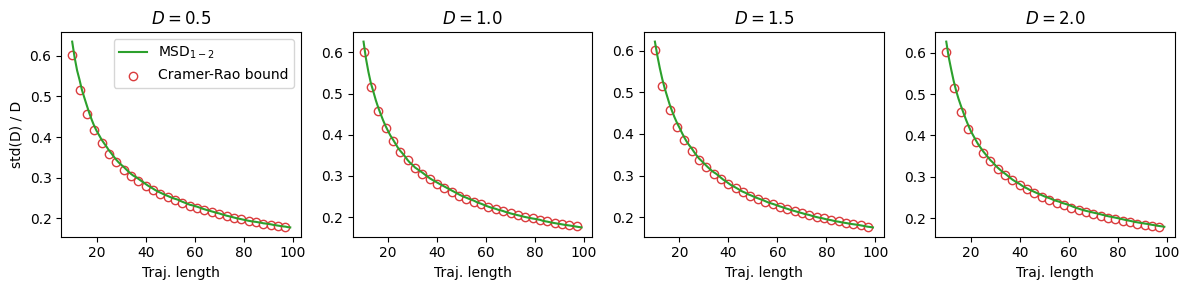

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (4*3,3), tight_layout = True)

for idx, (ax, std_d, D) in enumerate(zip(axs.flatten(), std_ds, Ds)):
    ax.plot(Ts, std_d/D, label = r'MSD$_{1-2}$', c = 'C2')
    ax.scatter(Ts[::3], CRLB_D(Ts, dim = 2)[::3], label = 'Cramer-Rao bound', alpha = 0.9, facecolor = 'w', edgecolor = 'C3')
    ax.set_title(fr'$D = {D}$')
axs[0].legend()
plt.setp(axs[0], ylabel = 'std(D) / D')
plt.setp(axs, xlabel = 'Traj. length');

#| hide
# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()